<a href="https://colab.research.google.com/github/mmistroni/Magentic-AlgoTrading101/blob/main/Restaurant_Menu_Cost_Calculator_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This is an Experiment to leverage Multimodal LLM to calculate how much does it cost to dine in Gabicce.
The notebook embeds images of restaurants menus and i will ask LLM to calculate how much does it cost for a family of 3 and a standard meal to eat in a restaurant in Gabicce Mare (Italy)
I have downloaded menu images, stored in the notebook and then generate a base64 representation for each of them which will be added as text cell in this notebook

In [ ]:
# This cell will generat a base64 so that i can embed all the images in my notebook. you dont need to run it
import base64
import os
from IPython.display import Image, display, Markdown

# Define the directory where your images are located
image_directory = 'menus'

# --- Step 1: List all image files in the specified directory ---
image_files = []
try:
    # Check if the directory exists
    if not os.path.exists(image_directory):
        print(f"Error: Directory '{image_directory}' not found in the current Colab session.")
        print("Please ensure you have uploaded your 'menus' folder correctly.")
    else:
        # Filter for common image extensions
        for filename in os.listdir(image_directory):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp')):
                image_files.append(filename)

    if not image_files:
        print(f"No image files found in '{image_directory}'. Please check the folder content.")
    else:
        print(f"Found {len(image_files)} image(s) in '{image_directory}': {', '.join(image_files)}")

except Exception as e:
    print(f"An error occurred while listing files: {e}")

# --- Step 2: Process and output Base64 for each found image ---
if image_files:
    print("\n--- Generating Base64 Markdown for all found images: ---")
    print("-----------------------------------------------------------------")

    for selected_filename in image_files:
        full_image_path = os.path.join(image_directory, selected_filename)

        print(f"\nProcessing '{selected_filename}'...")

        # --- Step 3: Read and Base64 encode the selected image ---
        try:
            with open(full_image_path, 'rb') as img_file:
                encoded_string = base64.b64encode(img_file.read()).decode('utf-8')

            # Determine MIME type based on file extension
            mime_type = "image/png" # Default
            if selected_filename.lower().endswith(('.jpg', '.jpeg')):
                mime_type = "image/jpeg"
            elif selected_filename.lower().endswith('.gif'):
                mime_type = "image/gif"
            elif selected_filename.lower().endswith('.bmp'):
                mime_type = "image/bmp"
            elif selected_filename.lower().endswith('.webp'):
                mime_type = "image/webp"

            # --- Step 4: Generate Markdown for embedding ---
            # You can customize the Alt Text here if needed
            alt_text = f"Image: {selected_filename}"
            markdown_code = f"![{alt_text}](data:{mime_type};base64,{encoded_string})"

            print(f"\n--- Markdown Code for '{selected_filename}': ---")
            print("-----------------------------------------------------------------")
            print(markdown_code)
            print("-----------------------------------------------------------------")

            print("\n--- Preview of the embedded image: ---")
            # --- Step 5: Display the image directly in the output for verification ---
            display(Image(data=base64.b64decode(encoded_string)))

            print("\n-----------------------------------------------------------------")
            print(f"Copy the Markdown code above for '{selected_filename}' and paste it into a new Markdown cell.")
            print("-----------------------------------------------------------------")


        except FileNotFoundError:
            print(f"Error: Image file '{full_image_path}' not found. It might have been deleted.")
        except Exception as e:
            print(f"An error occurred during encoding or display for '{selected_filename}': {e}")
else:
    print("\nNo images available to process. Please upload images to the 'menus' folder.")



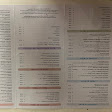

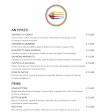

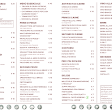

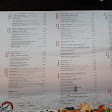

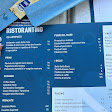

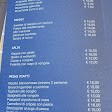

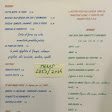

In [ ]:
import base64
import requests
import json
from PIL import Image
import io

# --- Configuration ---
# Replace with your actual Gemini API Key.
# In a real environment, you'd load this securely (e.g., from environment variables).
# For this Canvas environment, the __api_key__ variable will be provided at runtime.
API_KEY = "" # Leave this empty, Canvas will inject the API key.
GEMINI_API_URL = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent"

# --- Helper Function: Image to Base64 ---
def image_to_base64(image_path):
    """
    Converts an image file to a Base64 encoded string.
    This simulates retrieving an image from a data store and preparing it for the API.
    """
    try:
        with Image.open(image_path) as img:
            buffered = io.BytesIO()
            # Convert to RGB to ensure compatibility, as some images might be RGBA (e.g., PNGs)
            # and the model might prefer RGB.
            if img.mode == 'RGBA':
                img = img.convert('RGB')
            img.save(buffered, format="JPEG") # Use JPEG for smaller size and common compatibility
            return base64.b64encode(buffered.getvalue()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"Error converting image to base64: {e}")
        return None

# --- Function: Extract Menu Items using Gemini API ---
def extract_menu_from_image(base64_image_data, prompt_text):
    """
    Calls the Gemini API to extract menu items and prices from an image.
    It uses a structured response schema to get JSON output.
    """
    if not base64_image_data:
        return {"error": "No image data provided."}

    headers = {
        "Content-Type": "application/json",
    }

    # Define the structured schema for the response
    response_schema = {
        "type": "ARRAY",
        "items": {
            "type": "OBJECT",
            "properties": {
                "item": {"type": "STRING"},
                "price": {"type": "NUMBER"}
            },
            "required": ["item", "price"]
        }
    }

    payload = {
        "contents": [
            {
                "role": "user",
                "parts": [
                    {"text": prompt_text},
                    {
                        "inlineData": {
                            "mimeType": "image/jpeg", # Adjust mimeType if you save as PNG
                            "data": base64_image_data
                        }
                    }
                ]
            }
        ],
        "generationConfig": {
            "responseMimeType": "application/json",
            "responseSchema": response_schema
        }
    }

    try:
        response = requests.post(f"{GEMINI_API_URL}?key={API_KEY}", headers=headers, data=json.dumps(payload))
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        result = response.json()

        if result.get('candidates') and result['candidates'][0].get('content') and result['candidates'][0]['content'].get('parts'):
            # The API returns the JSON as a string within the 'text' field
            json_string = result['candidates'][0]['content']['parts'][0]['text']
            # Parse the JSON string into a Python object
            parsed_json = json.loads(json_string)
            return parsed_json
        else:
            print("Unexpected API response structure:", result)
            return {"error": "Could not extract menu items. Unexpected API response."}

    except requests.exceptions.RequestException as e:
        print(f"API request failed: {e}")
        return {"error": f"API request failed: {e}"}
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON response: {e}")
        print(f"Raw response text: {response.text}")
        return {"error": f"Failed to decode JSON response: {e}"}
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return {"error": f"An unexpected error occurred: {e}"}

# --- Function: Calculate Meal Cost ---
def calculate_meal_cost(extracted_menu, desired_items, num_people, price_increase_percent, coperto_per_person=2.50):
    """
    Calculates the total estimated cost for a meal based on extracted menu prices,
    desired items, number of people, and a price increase percentage.
    """
    total_food_cost = 0.0
    print("\n--- Calculating Meal Cost ---")
    print(f"Desired items for {num_people} people:")

    for item_name, quantity in desired_items.items():
        found_price = None
        # Try to find the item in the extracted menu (case-insensitive, partial match)
        for menu_item in extracted_menu:
            if item_name.lower() in menu_item['item'].lower():
                found_price = menu_item['price']
                break

        if found_price is not None:
            cost_for_item = found_price * quantity
            total_food_cost += cost_for_item
            print(f"- {quantity}x {item_name}: €{found_price:.2f} each -> €{cost_for_item:.2f}")
        else:
            print(f"- Warning: '{item_name}' not found in the extracted menu. Skipping this item.")
            # For items not found, we'll use a reasonable average from previous context
            # This is a fallback if the OCR/LLM misses something or if the item is generic
            if "patatine fritte" in item_name.lower():
                found_price = 4.50
            elif "insalata" in item_name.lower():
                found_price = 4.50
            elif "primi piatti di pasta" in item_name.lower() or "pasta" in item_name.lower():
                found_price = 15.00
            elif "pizza" in item_name.lower():
                found_price = 10.00
            else:
                found_price = 0.0 # Default to 0 if no reasonable fallback

            if found_price > 0:
                cost_for_item = found_price * quantity
                total_food_cost += cost_for_item
                print(f"  (Using estimated price: €{found_price:.2f} for {item_name} -> €{cost_for_item:.2f})")


    print(f"\nSubtotal for food before increase: €{total_food_cost:.2f}")

    # Apply price increase
    increased_food_cost = total_food_cost * (1 + price_increase_percent / 100)
    print(f"Subtotal for food after {price_increase_percent}% increase: €{increased_food_cost:.2f}")

    # Add coperto
    total_coperto_cost = coperto_per_person * num_people
    print(f"Coperto ({coperto_per_person:.2f} per person for {num_people} people): €{total_coperto_cost:.2f}")

    final_total_cost = increased_food_cost + total_coperto_cost
    print(f"\nEstimated total cost for {num_people} people: €{final_total_cost:.2f}")

    return final_total_cost

# --- Main Execution ---
if __name__ == "__main__":
    # --- Step 1: Prepare the Image ---
    # We'll use one of the previously uploaded images.
    # In a real RAG scenario, you'd retrieve the image data directly from your store.
    # For demonstration, ensure 'menu maremosso temporaneo portrait.pages.png' is accessible
    # in the same directory as this notebook, or provide its full path.
    image_file_path = "menu maremosso temporaneo portrait.pages.png" # Example image
    print(f"Loading image from: {image_file_path}")
    base64_image = image_to_base64(image_file_path)

    if base64_image:
        # --- Step 2: Extract Menu Items using Gemini ---
        print("\n--- Calling Gemini API to extract menu items ---")
        prompt = "Extract all menu items and their prices from this image. Provide the output as a JSON array of objects, where each object has 'item' (string) and 'price' (number) keys. If a price is not explicitly stated, use 0.0. Do not include any introductory or concluding text, just the JSON array."
        extracted_menu_data = extract_menu_from_image(base64_image, prompt)

        if isinstance(extracted_menu_data, list):
            print("\n--- Extracted Menu Items ---")
            for item in extracted_menu_data:
                print(f"Item: {item.get('item', 'N/A')}, Price: €{item.get('price', 0.0):.2f}")

            # --- Step 3: Calculate the Cost for Your Group ---
            num_people = 3
            # Define the items your group typically orders and their quantities
            desired_items_for_group = {
                "patatine fritte": 1,
                "insalata": 1,
                "spaghetti": 2, # Assuming 'spaghetti' is a common pasta dish, adjust if needed
                "pizza": 1
            }
            price_increase_percent = 15

            # Calculate and print the final cost
            final_cost = calculate_meal_cost(
                extracted_menu_data,
                desired_items_for_group,
                num_people,
                price_increase_percent
            )
            print(f"\nFinal estimated cost for your group in Gabicce: €{final_cost:.2f}")

        else:
            print("\nFailed to extract menu data. Please check the image and API response.")
            print(extracted_menu_data) # Print the error message
    else:
        print("Could not process the image. Please ensure the path is correct and the file is valid.")

In [ ]:
import pandas as pd
from google.colab import files, drive
import io
from PIL import Image # For image handling
import matplotlib.pyplot as plt # For displaying images
import os # For file system operations

print("--- Method 1: Interactive File Upload during Runtime ---")
# This method prompts you to upload files directly from your computer
# It's useful if you want the user to select a file when the notebook runs.
try:
    uploaded = files.upload() # This will open a file selection dialog
    for filename in uploaded.keys():
        print(f'User uploaded file: {filename}')

        # Example: Reading a text file
        if filename.endswith('.txt'):
            content = uploaded[filename].decode('utf-8')
            print(f'\nContent of {filename}:\n{content[:200]}...') # Print first 200 chars
        # Example: Reading a CSV file into a Pandas DataFrame
        elif filename.endswith('.csv'):
            df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))
            print(f'\nDataFrame from {filename} (first 5 rows):\n')
            print(df.head())
        # Example: Reading an image file
        elif filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):
            image = Image.open(io.BytesIO(uploaded[filename]))
            print(f'\nImage {filename} loaded. Size: {image.size}, Format: {image.format}')
            plt.imshow(image)
            plt.title(f'Uploaded Image: {filename}')
            plt.axis('off')
            plt.show()
        else:
            print(f"Unsupported file type for {filename}. Content not displayed.")

except Exception as e:
    print(f"An error occurred during interactive upload: {e}")
    print("This might happen if no file was selected or if the environment is not Colab.")

